In [77]:
import matplotlib.pyplot as plt
import os
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
import numpy as np
plt.style.use('seaborn-colorblind')
import torch
from torch.distributions import Categorical

# import torch
# from torch.distributions import Categorical

# soft = np.full((10),0.1)
# max_val = Categorical(probs = torch.from_np(soft)).entropy().np()
# print(max_val)

import matplotlib
# # matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

plt.style.use('seaborn-colorblind')

def load(directory):
    metric_directory = directory+'/metrics/'
    ground_truths = list()
    outputs = list()
    
    for run in range(0,3):
        ground_truth = np.load(metric_directory+'ground-truth-run-'+str(run)+'.npy')
        output = np.load(metric_directory+'raw-softmax-run-'+str(run)+'.npy')
        ground_truths.append(ground_truth)
        outputs.append(output)
        
    ground_truths = np.array(ground_truths)
    outputs = np.array(outputs)
        
    mac_readings = np.load(directory+'/metrics/layerwise_macs.npy')
    
    return ground_truths,outputs,mac_readings

def get_label(directory):
    model = directory.split('/')[2]
    branch_weights = np.load(directory+"/metrics/branch-weights-"+model+".npy")
    string = model + ' ('
    for weight in branch_weights:
        weight = np.round(weight,decimals=3)
        string = string + str(weight) + " : "
    string = string[:-3]+')'
    return(string)

def get_exit_p(exit_readings):
    
    exit_p = np.zeros(4)

    for exit in range(len(exit_p)): 
        exit_p[exit] = np.count_nonzero(exit_readings==exit)
    return(exit_p/len(exit_readings))

def get_MACs_acc(exits, macs, important, layers):
    layerwise_macs = np.take(macs,important)
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)

    exit_p = get_exit_p(exits)

    avg_powers = np.sum(np.multiply(exit_p,powers))

    return avg_powers, exit_p

def branch_MACs(directory, runs, important, layers):
    model = directory.split('/')[2]
    _,_, macs = load(directory)
    layerwise_macs = np.take(macs,important)
    label = get_label(directory)
    accuracies = np.load(directory+"/metrics/branch-val-accuracies-"+model+".npy")
    mean_accuracies = np.mean(accuracies,axis=0)
    std_accuracies = np.std(accuracies,axis=0)
    
    accs = np.zeros(4)
    std = np.zeros(4)
    for idx,row in enumerate(mean_accuracies):
        branch_best = np.argmax(row)
        accs[idx] = mean_accuracies[idx,branch_best]
        std[idx] = std_accuracies[idx,branch_best]
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)
    
    return powers, accs, std, label

def get_acc_profile(ground_truth,outputs):
    ground_truth = ground_truth.astype(int)
    number_class = outputs.shape[3]
    preds = np.argmax(outputs,axis=-1)
    correct = np.zeros_like(outputs)
    for run in range(correct.shape[0]):

        one_hot_labels = np.eye(number_class)[ground_truth[run,:]]
        one_hot_predictions = np.eye(number_class)[preds[run,:,:]]
            
        run_correct = np.equal(one_hot_labels,one_hot_predictions).astype(int)

        correct[run,:,:,:] = run_correct*one_hot_predictions

        
    n_values = correct.shape[-2]

    num_examples = n_values/number_class

    correct_count = np.sum(correct,axis=2)/num_examples
    mean_acc = np.mean(correct_count,axis=0)

    return mean_acc

In [78]:
def entropic(directory,layers,branches,n_thresh=100):

    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)
    thresholds = np.linspace(max_entropy,0,n_thresh)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)

            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                for branch_idx, branch_entr in enumerate(entropies):
                    if branch_entr < threshold:
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)

        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def entropic_with_mutual_agreement(directory,layers,branches,n_thresh=100):

    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)


    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    thresholds = np.linspace(max_entropy,0,n_thresh)
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)

            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                for branch_idx, branch_entr in enumerate(entropies):
                    if (branch_entr < threshold) or ((np.argmax(run_output[branch_idx,inp_idx,:]) == np.argmax(run_output[branch_idx-1,inp_idx,:])) and branch_idx > 0):
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)

        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def RandomChoice(directory,layers,branches):
    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((runs))
    MACs = np.zeros((runs))
    percentages = np.zeros((n_branches,runs))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((runs,n_inputs),n_branches-1)

    for run in range(runs):
        run_output = outputs[run,:,:,:]
        branch_predictions = np.argmax(run_output,axis=2)
        branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

        entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

        exits = np.full(n_inputs,3)
        predictions = np.argmax(run_output[-1,:,:],1)

        for inp_idx, _ in enumerate(ground_truths[0]):
            entropies = entropy[:,inp_idx]
            exits[inp_idx] = np.random.randint(4)
            predictions[inp_idx] = np.argmax(run_output[exits[inp_idx],inp_idx,:])

        accuracies[run] = np.mean(np.equal(ground_truths[run],predictions))
        MACs[run], percentages[:,run] = get_MACs_acc(exits, power, layers, branches)

    accuracy = np.array(np.mean(accuracies),np.std(accuracies))
    MAC = np.array(np.mean(MACs),np.std(MACs))
    percentage = np.mean(percentages,axis=1)

    return(accuracy,MAC,percentage,label,branch_accs,branch_exits)

def TrainingAccConf(directory,layers,branches):
    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    max_entropy = np.log(n_classes)

    acc_prof =  get_acc_profile(ground_truths,outputs)

    accuracies = np.zeros((runs))
    MACs = np.zeros((runs))
    percentages = np.zeros((n_branches,runs))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((runs,n_inputs),n_branches-1)

    for run in range(runs):
        run_output = outputs[run,:,:,:]
        branch_predictions = np.argmax(run_output,axis=2)
        branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

        entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

        exits = np.full(n_inputs,3)
        predictions = np.argmax(run_output[-1,:,:],1)

        for inp_idx, _ in enumerate(ground_truths[0]):
            normalised_entropies = entropy[:,inp_idx]/max_entropy
            for branch_idx in range(0,n_branches):
                if normalised_entropies[branch_idx] < 0.25*acc_prof[branch_idx,branch_predictions[branch_idx,inp_idx]]:
                    exits[inp_idx] = branch_idx
                    predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                    break

        accuracies[run] = np.mean(np.equal(ground_truths[run],predictions))
        MACs[run], percentages[:,run] = get_MACs_acc(exits, power, layers, branches)

    accuracy = np.array(np.mean(accuracies),np.std(accuracies))
    MAC = np.array(np.mean(MACs),np.std(MACs))
    percentage = np.mean(percentages,axis=1)

    return(accuracy,MAC,percentage,label,branch_accs,branch_exits)

def ThresholdTrainAccConf(directory,layers,branches,n_thresh=100):

    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]
    acc_prof =  get_acc_profile(ground_truths,outputs)

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    max_eta = 2.0
    thresholds = np.linspace(0,max_eta,n_thresh)
    print("N Classes: ",n_classes,"\tMax eta:",max_eta)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)
            branch_probs = np.max(run_output,axis=2)

            for inp_idx, _ in enumerate(ground_truths[0]):
                normalised_entropies = entropy[:,inp_idx]/max_entropy
                for branch_idx in range(0,n_branches):
                    if branch_probs[branch_idx,inp_idx] > threshold*acc_prof[branch_idx,branch_predictions[branch_idx,inp_idx]]:
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)

        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def covariance_change(directory,layers,branches,n_thresh=10):

    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    print("N Classes: ",n_classes)
    thresholds = np.linspace(0.7,1.0,n_thresh)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)

            for inp_idx, _ in enumerate(ground_truths[0]):
                covariances = np.corrcoef(run_output[:,inp_idx,:])
                for branch_idx in range(covariances.shape[0]):
                    
                    if branch_idx > 0:
                        cov_change = covariances[branch_idx,branch_idx-1]
                    else:
                        cov_change = 0.0
            
                    if cov_change > threshold:
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)
        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def entropic_covariance_change(directory,layers,branches,n_thresh=100):
    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    thresholds = np.linspace(max_entropy,0,n_thresh)
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()
            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)
            
            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                covariances = np.corrcoef(run_output[:,inp_idx,:])
                for branch_idx, branch_entr in enumerate(entropies):
                    
                    if branch_idx > 0:
                        cov_change = covariances[branch_idx,branch_idx-1]
                    else:
                        cov_change = 0.0
            
                    if cov_change > 0.7 or (branch_entr < threshold):
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/N
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)
        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def entropic_voting(directory,layers,branches,n_thresh=100):
    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    thresholds = np.linspace(max_entropy,0,n_thresh)
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)
            
            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                
                for branch_idx, branch_entr in enumerate(entropies):

                    confidences = 1-(entropies[:branch_idx+1]/max_entropy)
                    voting_softmax = np.sum(run_output[:branch_idx+1,inp_idx,:]*confidences[:,np.newaxis],axis=0)
                    voting_softmax = voting_softmax/np.sum(voting_softmax)
                    vote_ent = Categorical(probs = torch.from_numpy(voting_softmax)).entropy().numpy()
            
                    if (vote_ent < threshold):
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)
        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def top5_entropy(directory,layers,branches,n_thresh=100):
    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    thresholds = np.linspace(max_entropy,0,n_thresh)
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,3)
            predictions = np.argmax(run_output[-1,:,:],1)
            
            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                
                for branch_idx, branch_entr in enumerate(entropies):

                    top5_idx = run_output[branch_idx,inp_idx,:].argsort()[-5:]
                    top5_probs = run_output[branch_idx,inp_idx,top5_idx]
                    top5_entropy = Categorical(probs = torch.from_numpy(top5_probs)).entropy().numpy()
            
                    if (top5_entropy < threshold):
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)
        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def one_hot_votes(directory,layers,branches,n_thresh=100):
    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    # thresholds = np.linspace(0,n_branches-1,n_thresh)
    # print("N Classes: ",n_classes,"\tMax Probability:",n_branches-1)

    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    thresholds = np.linspace(max_entropy,0,n_thresh)
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            exits = np.full(n_inputs,n_branches-1)
            predictions = np.argmax(run_output[-1,:,:],1)

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()
        
            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                for branch_idx, branch_entr in enumerate(entropies):
                    one_hot = np.zeros_like(run_output[:branch_idx+1,inp_idx,:])

                    pred_idx = np.zeros((2,branch_idx+1),dtype=int)
                    pred_idx[-1,:] = branch_predictions[:branch_idx+1,inp_idx]
                    pred_idx[0,:] = np.arange(branch_idx+1)

                    one_hot[pred_idx[0],pred_idx[1]] = 1
                    one_hot_probs = run_output[:branch_idx+1,inp_idx,:]*one_hot
                    total_one_hot = np.sum(one_hot_probs,axis=0)
                    max_prob = np.max(total_one_hot)
            
                    # if (max_prob > threshold):
                    #     exits[inp_idx] = branch_idx
                    #     predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                    #     branch_exits[thresh_idx,run,inp_idx] = branch_idx
                    #     break
            
                    dot = -1 
                    if branch_idx>0:
                        dot = np.dot(one_hot[branch_idx],one_hot[branch_idx-1])
                    
                    if (branch_entr < threshold) or dot > 0:
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)
        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

def mutual_agreement(directory,layers,branches):
    label = get_label(directory)

    ground_truths, outputs, power = load(directory)

    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]

    n_classes = outputs.shape[3]
    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    
    accuracies = np.zeros((runs))
    MACs = np.zeros((runs))
    percentages = np.zeros((n_branches,runs))

    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((runs,n_inputs),n_branches-1)

    for run in range(runs):
        run_output = outputs[run,:,:,:]
        branch_predictions = np.argmax(run_output,axis=2)
        branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

        entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

        exits = np.full(n_inputs,3)
        predictions = np.argmax(run_output[-1,:,:],1)

        for inp_idx, _ in enumerate(ground_truths[0]):
            entropies = entropy[:,inp_idx]
            for branch_idx in range(1,n_branches):
                if (np.argmax(run_output[branch_idx,inp_idx,:]) == np.argmax(run_output[branch_idx-1,inp_idx,:])):
                    exits[inp_idx] = branch_idx
                    predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                    break

        accuracies[run] = np.mean(np.equal(ground_truths[run],predictions))
        MACs[run], percentages[:,run] = get_MACs_acc(exits, power, layers, branches)

    accuracy = np.array(np.mean(accuracies),np.std(accuracies))
    MAC = np.array(np.mean(MACs),np.std(MACs))
    percentage = np.mean(percentages,axis=1)
    return(accuracy,MAC,percentage,label,branch_accs,branch_exits)

def predicted_match(directory,layers,branches,n_thresh=100):

    label = get_label(directory)
    ground_truths, outputs, power = load(directory)
    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]
    n_classes = outputs.shape[3]

    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)
    
    n_classes = outputs.shape[3]
    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    thresholds = np.linspace(0.2,1,n_thresh)
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)
    
    for run in range(runs):
        run_output = outputs[run,:,:,:]
        branch_predictions = np.argmax(run_output,axis=2)
        branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

        exits = np.full(n_inputs,3)
        predictions = np.argmax(run_output[-1,:,:],1)

        chosen = outputs[run,:]
        one_hot = np.zeros_like(chosen)
        predictions = np.argmax(outputs[run,:],axis=-1)

        for branch in range(chosen.shape[0]):
            for input in range(chosen.shape[1]):
                if predictions[branch,input] == predictions[-1,input]:
                    one_hot[branch,input,predictions[branch,input]] = 1

        totals = np.sum(one_hot,axis=1)
        match_per = totals/totals[-1,:]
        print(match_per.shape)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()

            exits = np.full(n_inputs,n_branches-1)
            predictions = np.argmax(run_output[-1,:,:],1)
        
            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                for branch_idx, branch_entr in enumerate(entropies):
                    predicted_class = branch_predictions[branch_idx,inp_idx]
                    if match_per[branch_idx,predicted_class] >= threshold: #branch_entr < threshold or 
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break
            
            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/n_inputs
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)
        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
        
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)

from kneed import KneeLocator

def quantify(MACs, accuracies, plot=True):

    x = MACs
    y = accuracies

    kn = KneeLocator(x[40:], y[40:], curve='concave', direction='increasing')
    log_kn = np.log(kn.knee)

    x = np.log(x)
    y = np.log(y)

    power_y, power_x = y[x<log_kn], x[x<log_kn]
    power_min = np.min(power_x)
    power_max = np.max(power_x)

    const_y, const_x = y[x>log_kn], x[x>log_kn]
    lin_min = np.min(const_x)
    lin_max = np.max(const_x)

    const = np.mean(const_y)

    def power(x,k1,k2):
        return (k1*x + k2)

    def const(x,k1):
        return x*0 + k1

    power_popt, power_cov = optimize.curve_fit(power, power_x, power_y) 
    const_popt, const_cov = optimize.curve_fit(const, const_x, const_y)

    # print(power_popt,const_popt,log_kn)
    values = [power_popt[0],const_popt[0], log_kn, [x[0],x[-1]]]

    if plot == True:
        plt.plot(power_x, power_y, 'bx-')
        plt.plot(x, power(x, *power_popt), '--',label='power',color='b')

        plt.plot(const_x, const_y, 'rx-')
        plt.plot(x, const(x, *const_popt), '--', color='r')

        plt.vlines(log_kn, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

    return(values)
    
def performance(m,c,x0,xm,xl,gamma=8,eta=10):
    prog = gamma*(m*(1+c))/np.log((4*xl+(xm-x0)))
    perf = np.abs(eta*(3*c/xm))
    print('Progressiveness:',prog,"\tPerformance:",perf)
    return(prog + perf)

def plot_branch_accuracy(branch_accs,exits,thresholds):
    branch_accuracies = np.zeros((branch_accs.shape[0],branch_accs.shape[1],thresholds.shape[0]))
    print(branch_accuracies.shape)
    for run in range(0,branch_accuracies.shape[0]):
        for thresh_idx, _ in enumerate(thresholds):
            for branch in range(0,4):
                exit_idx = np.argwhere(exits[thresh_idx,run,:] == branch)
                branch_accuracies[run,branch,thresh_idx] = np.sum(branch_accs[run,branch,exit_idx])/exit_idx.shape[0]

    mean_accuracies = np.mean(branch_accuracies,axis=0)
    std_accuracies = np.std(branch_accuracies,axis=0)
    return(mean_accuracies,std_accuracies)


In [79]:
#Testing new ones

mobilenet_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobilenet_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

directory = "../trained-models/BranchedMobileNet/CIFAR100/wb102-b202-b302/"

# cov_acc,cov_MACs,cov_percentages,cov_thresholds,label,branch_accs,cov_exits = covariance_change(directory,mobilenet_layers,mobilenet_branches)

In [80]:
#testing with single directory

n_thresh=50

mobilenet_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobilenet_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

resnet_layers = [1,2,3,16,31,46,61,62,63,64]
resnet_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

directory = "../trained-models/BranchedMobileNet/CIFAR100/wb102-b202-b302/"

prob_accuracies,prob_MACs,prob_percentages,prob_thresholds,label,branch_accs,prob_exits = predicted_match(directory,mobilenet_layers,mobilenet_branches,n_thresh=n_thresh)
rand_acc,rand_MACs,rand_percentages,label,branch_accs,rand_exits = RandomChoice(directory,mobilenet_layers,mobilenet_branches)
agr_accuracies,agr_MACs,agr_percentages,agr_thresholds,label,branch_accs,agr_exits = entropic_with_mutual_agreement(directory,mobilenet_layers,mobilenet_branches,n_thresh=n_thresh)
mut_acc,mut_MAC,mut_percentage,label,branch_accs,mut_exit = mutual_agreement(directory,mobilenet_layers,mobilenet_branches)
cov_acc,cov_MACs,cov_percentages,cov_thresholds,label,branch_accs,cov_exits = one_hot_votes(directory,mobilenet_layers,mobilenet_branches,n_thresh=n_thresh)
accuracies,MACs,percentages,thresholds,label,branch_accs,exits = entropic(directory,mobilenet_layers,mobilenet_branches,n_thresh=n_thresh)

directory = "../trained-models/BranchedResNet18/CIFAR100/wb102-b202-b302/"

# agr_accuracies_r,agr_MACs_r,agr_percentages_r,agr_thresholds_r,label_r,branch_accs_r,agr_exits_r = predicted_match(directory,resnet_layers,resnet_branches,n_thresh=n_thresh)
rand_acc_r,rand_MACs_r,rand_percentages_r,label_r,branch_accs_r,rand_exits_r = RandomChoice(directory,resnet_layers,resnet_branches)
train_accs_r,train_MACs_r,train_percentages_r,train_thresholds,label_r,train_branch_accs_r,train_exits_r = ThresholdTrainAccConf(directory,resnet_layers,resnet_branches,n_thresh=n_thresh)
mut_acc_r,mut_MAC_r,mut_percentage_r,label_r,branch_accs_r,mut_exit_r = mutual_agreement(directory,resnet_layers,resnet_branches)
agr_accuracies_r,agr_MACs_r,agr_percentages_r,agr_thresholds_r,label_r,branch_accs_r,agr_exits_r = entropic_with_mutual_agreement(directory,resnet_layers,resnet_branches,n_thresh=n_thresh)
cov_acc_r,cov_MACs_r,cov_percentages_r,cov_thresholds_r,label_r,branch_accs_r,cov_exits_r = one_hot_votes(directory,resnet_layers,resnet_branches,n_thresh=n_thresh)
accuracies_r,MACs_r,percentages_r,thresholds_r,label_r,branch_accs_r,exits_r = entropic(directory,resnet_layers,resnet_branches,n_thresh=n_thresh)

N Classes:  100 	Max Entropy: 4.605170185988082
(4, 100)
(4, 100)
(4, 100)
N Classes:  100 	Max Entropy: 4.605170185988082
N Classes:  100 	Max Entropy: 4.605170185988082
N Classes:  100 	Max Entropy: 4.605170185988082
N Classes:  100 	Max eta: 2.0
N Classes:  100 	Max Entropy: 4.605170185988082
N Classes:  100 	Max Entropy: 4.605170185988082
N Classes:  100 	Max Entropy: 4.605170185988082


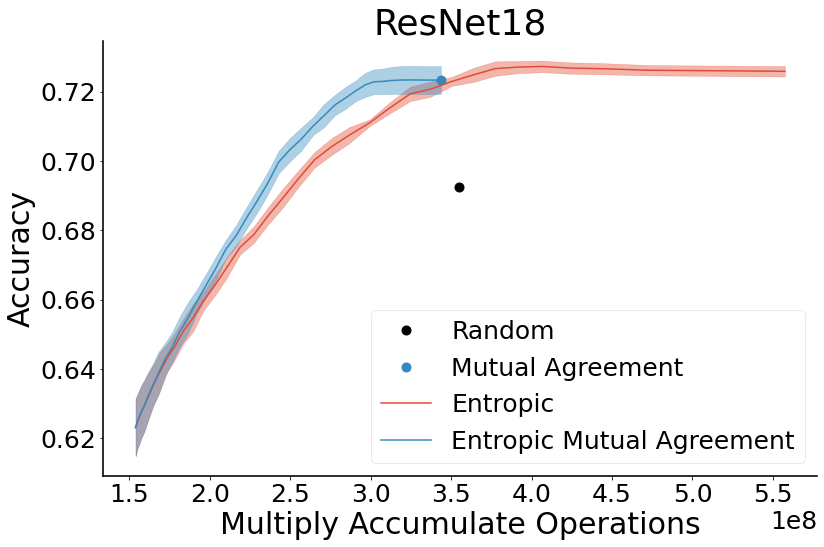

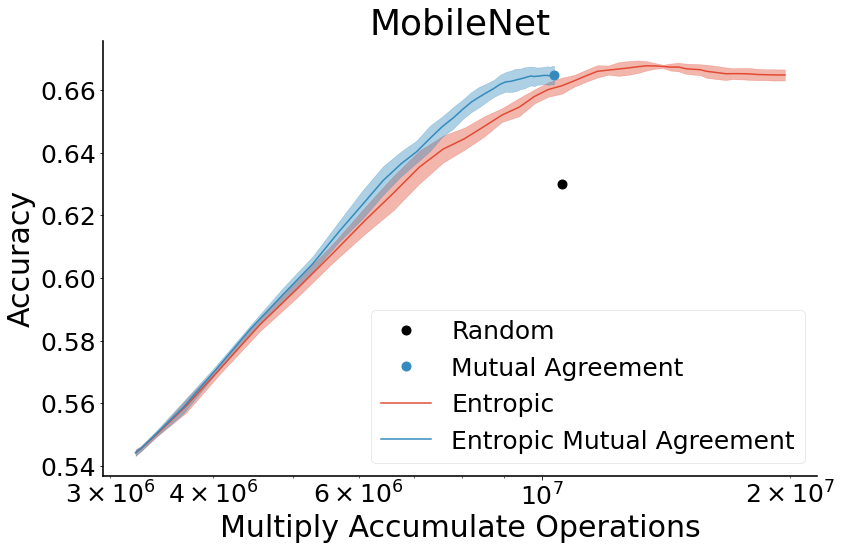

In [81]:
import matplotlib.pyplot as plt
height = 8
width = height*1.6
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.linewidth'] = 1.6
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 25
#plotting test results
# mean_accuracies, _ = plot_branch_accuracy(branch_accs_r,exits_r,thresholds)
# power,branch_base_accs,branch_base_std,label = branch_MACs(directory,3,resnet_layers,resnet_branches)

# print(branch_base_accs)

plt.plot(rand_MACs_r,rand_acc_r,'ko',label=('Random'), markersize=9)
plt.plot(mut_MAC_r,mut_acc_r,'o',label=('Mutual Agreement'),color='C1', markersize=9)
# plt.plot(train_MACs_r,train_accs_r,'o',label=('Mutual Agreement: '+label))

# plt.plot(train_MACs_r[0],train_accs_r[0],color='C7',label=('Training Acc '+label))
# plt.fill_between(train_MACs_r[0],train_accs_r[0]+train_accs_r[1],train_accs_r[0]-train_accs_r[1],color='C7',alpha=0.4)

plt.plot(MACs_r[0],accuracies_r[0],label=('Entropic'),color='C0')
plt.fill_between(MACs_r[0],accuracies_r[0]+accuracies_r[1],accuracies_r[0]-accuracies_r[1],alpha=0.4,color='C0')

plt.plot(agr_MACs_r[0],agr_accuracies_r[0],label=('Entropic Mutual Agreement'),color='C1')
plt.fill_between(agr_MACs_r[0],agr_accuracies_r[0]+agr_accuracies_r[1],agr_accuracies_r[0]-agr_accuracies_r[1],alpha=0.4,color='C1')

# plt.plot(prob_MACs[0],prob_accuracies[0],color='C7',label=('Probability of Matching: '+label))
# plt.fill_between(prob_MACs[0],prob_accuracies[0]+prob_accuracies[1],prob_accuracies[0]-prob_accuracies[1],color='C7',alpha=0.4)

# plt.plot(cov_MACs_r[0],cov_acc_r[0],color='C8',label=('Matrix Operation MA: '+label))
# plt.fill_between(cov_MACs_r[0],cov_acc_r[0]+cov_acc_r[1],cov_acc_r[0]-cov_acc_r[1],color='C8',alpha=0.4)


# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.ylabel('Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.legend()
plt.title('ResNet18')
plt.savefig('resnet-agreement.pdf')
plt.show()




plt.plot(rand_MACs,rand_acc,'ko',label=('Random'), markersize=9)
plt.plot(mut_MAC,mut_acc,'o',label=('Mutual Agreement'),color='C1', markersize=9)

plt.plot(MACs[0],accuracies[0],label='Entropic',color='C0')
plt.fill_between(MACs[0],accuracies[0]+accuracies[1],accuracies[0]-accuracies[1],alpha=0.4,color='C0')

plt.plot(agr_MACs[0],agr_accuracies[0],label=('Entropic Mutual Agreement'),color='C1')
plt.fill_between(agr_MACs[0],agr_accuracies[0]+agr_accuracies[1],agr_accuracies[0]-agr_accuracies[1],alpha=0.4,color='C1')


# plt.plot(cov_MACs[0],cov_acc[0],color='C8',label=('Matrix Operation MA: '+label))
# plt.fill_between(cov_MACs[0],cov_acc[0]+cov_acc[1],cov_acc[0]-cov_acc[1],color='C8',alpha=0.4)

plt.xscale('log')
# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.legend()
plt.title('MobileNet')
plt.xlabel('Multiply Accumulate Operations')
plt.ylabel('Accuracy')
plt.savefig('mobilenet-agreement.pdf')
plt.show()


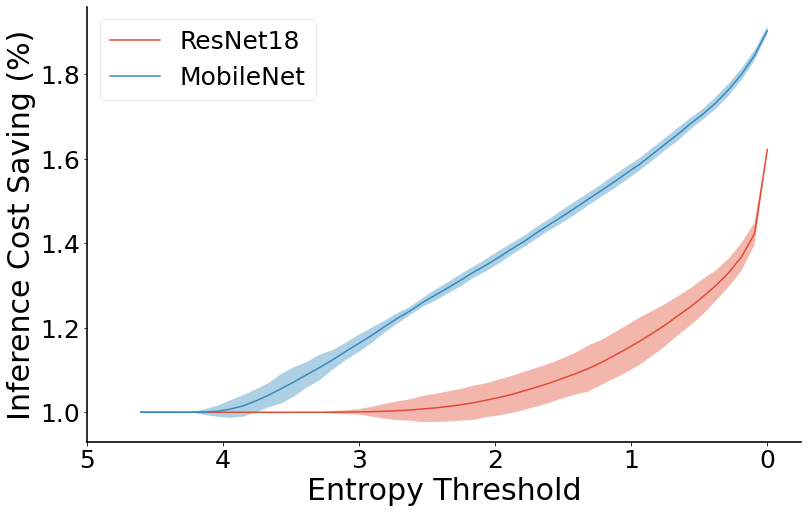

In [82]:
n_classes = 100
p = 1.0 /n_classes
max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
thresholds = np.linspace(max_entropy,0,n_thresh)

ResNetImprovement = 1/(agr_MACs_r[0]/MACs_r[0])
MobImprovement = 1/(agr_MACs[0]/MACs[0])

ResNetErr = ResNetImprovement*(agr_MACs_r[1]/agr_MACs_r[0] + MACs_r[1]/MACs_r[0])
MobErr = MobImprovement*(agr_MACs[1]/agr_MACs[0] + MACs[1]/MACs[0])

plt.plot(thresholds,ResNetImprovement,label='ResNet18')
plt.plot(thresholds,MobImprovement,label='MobileNet')

plt.fill_between(thresholds,ResNetImprovement+ResNetErr,ResNetImprovement-ResNetErr,alpha=0.4)
plt.fill_between(thresholds,MobImprovement+MobErr,MobImprovement-MobErr,alpha=0.4)

plt.ylabel('Inference Cost Saving (%)')
plt.xlabel('Entropy Threshold')
plt.xlim(5,-0.25)
# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.legend()
plt.savefig('improvement.pdf')
plt.show()

Mobilenet Entropic
Progressiveness: 0.15549965174635885 	Performance: 0.7284231932453145
Total: 0.8839228449916733

Mobilenet Entropic Agreement
Progressiveness: 0.20562292098890836 	Performance: 0.7582935743826841
Total: 0.9639164953715924

ResNet Entropic
Progressiveness: 0.23710290198800327 	Performance: 0.4758214474049619
Total: 0.7129243493929651

ResNet Entropic Agreement
Progressiveness: 0.29645359597405824 	Performance: 0.4944592493113096
Total: 0.7909128452853678


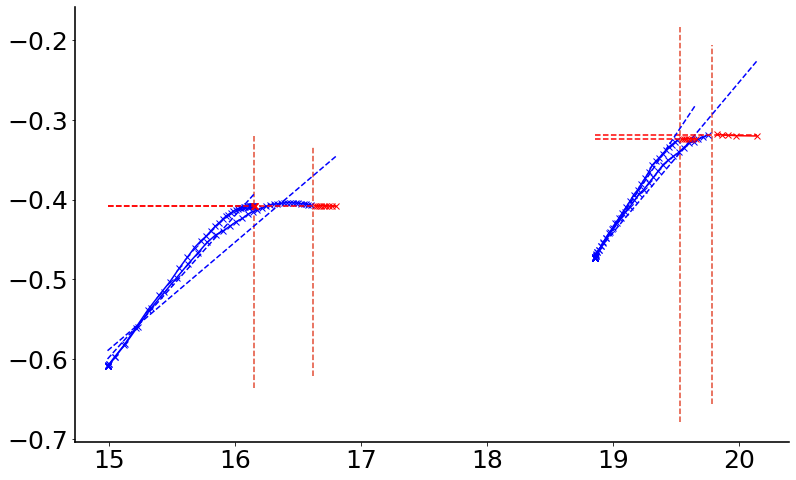

In [83]:
values=list()
from scipy import optimize
print('Mobilenet Entropic')
value = quantify(MACs[0],accuracies[0])
P = performance(value[0],value[1],value[2],value[3][1],value[3][0])
print('Total:',P)
values.append(value)

print('\nMobilenet Entropic Agreement')
value = quantify(agr_MACs[0],agr_accuracies[0])
P = performance(value[0],value[1],value[2],value[3][1],value[3][0])
print('Total:',P)
values.append(value)

print('\nResNet Entropic')
value = quantify(MACs_r[0],accuracies_r[0])
P = performance(value[0],value[1],value[2],value[3][1],value[3][0])
print('Total:',P)
values.append(value)

print('\nResNet Entropic Agreement')
value = quantify(agr_MACs_r[0],agr_accuracies_r[0])
P = performance(value[0],value[1],value[2],value[3][1],value[3][0])
print('Total:',P)
values.append(value)


plt.show()


N Classes:  10 	Max Entropy: 2.3025850929940455
N Classes:  10 	Max Entropy: 2.3025850929940455
N Classes:  10 	Max Entropy: 2.3025850929940455
N Classes:  10 	Max Entropy: 2.3025850929940455


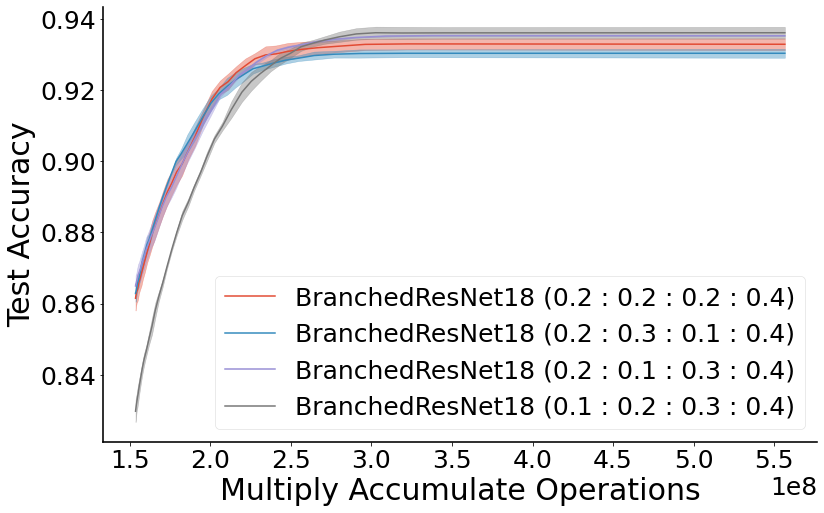

In [84]:
resnet_layers = [1,2,3,16,31,46,61,62,63,64]
resnet_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]
colours = ['C0','C1','C2','C3']
models = ['CA-wb102-b202-b302','CA-wb102-b203-b301','CA-wb102-b201-b303','CA-wb101-b202-b303']
n_thresh=50

for idx, model in enumerate(models):
    directory = "../trained-models/BranchedResNet18/CIFAR10/"+model+"/"
    accuracies,MACs,percentages,thresholds,label,branch_accs,exits = entropic(directory,resnet_layers,resnet_branches,n_thresh=n_thresh)
    plt.plot(MACs[0],accuracies[0],label=(label),color=colours[idx])
    plt.fill_between(MACs[0],accuracies[0]+accuracies[1],accuracies[0]-accuracies[1],alpha=0.4,color=colours[idx])

# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.ylabel('Test Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.legend()
# plt.title('ResNet18')
plt.savefig('resnet-inference.pdf')
plt.show()